In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install mediapipe

Hand landmarks detected!


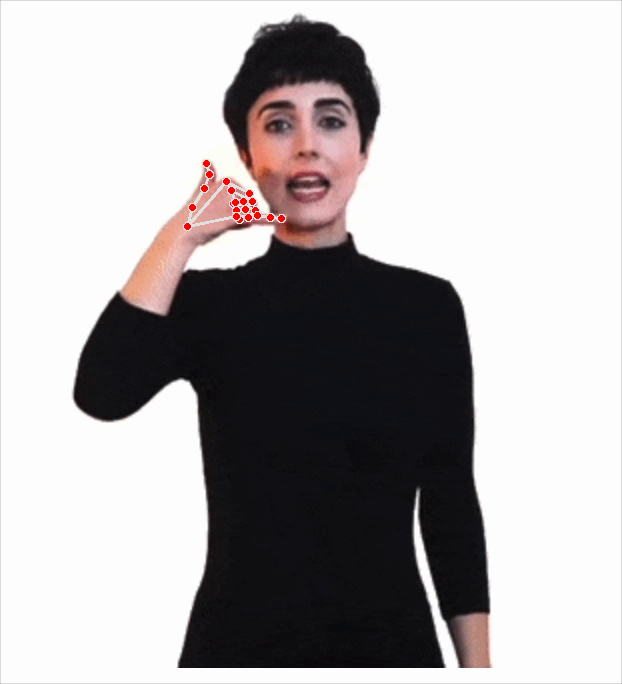

In [ ]:
import mediapipe as mp
import cv2
from google.colab.patches import cv2_imshow

# MediaPipe models
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

# Initialize the hand model
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)

# A path to an image for testing
image_path = "/content/drive/MyDrive/ElectiveDesignSignLanguage/TurkIsaretDili.v1i.coco/deneme.jpg"

# Reading and processing the image
image = cv2.imread(image_path)

if image is None:
    print("Image could not be loaded! Please check the file path.")
else:
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = hands.process(image_rgb)

    # Checking the result
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(image, hand_landmarks, mp_hands.HAND_CONNECTIONS)
            print("Hand landmarks detected!")

    # Show the image
    cv2_imshow(image)


In [ ]:
import os
import mediapipe as mp
import cv2
import pandas as pd
import json

In [ ]:
# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands

In [ ]:
# Paths for images and annotation
base_folder = "/content/drive/MyDrive/ElectiveDesignSignLanguage/TurkIsaretDili.v1i.coco"
image_folders = {
    "train": os.path.join(base_folder, "train"),
    "test": os.path.join(base_folder, "test"),
    "valid": os.path.join(base_folder, "valid")
}

# Define annotation paths for train, test, and validation sets
annotation_paths = {
    "train": os.path.join(base_folder, "annotations/annotations_train.coco.json"),
    "test": os.path.join(base_folder, "annotations/annotations_test.coco.json"),
    "valid": os.path.join(base_folder, "annotations/annotations_valid.coco.json")
}


**Loading Annotations**

In [ ]:
import json

# Load annotation files
with open(annotation_paths["train"], "r") as f:
    annotations_train = json.load(f)

with open(annotation_paths["valid"], "r") as f:
    annotations_valid = json.load(f)

with open(annotation_paths["test"], "r") as f:
    annotations_test = json.load(f)

# Print basic information about each dataset
print(f"Number of images in train annotations: {len(annotations_train['images'])}")
print(f"Number of images in valid annotations: {len(annotations_valid['images'])}")
print(f"Number of images in test annotations: {len(annotations_test['images'])}")

Number of images in train annotations: 20018
Number of images in valid annotations: 1908
Number of images in test annotations: 945


In [ ]:
# Check for missing images in train, valid, and test folders
missing_train = [img["file_name"] for img in annotations_train["images"] if not os.path.exists(os.path.join(image_folders["train"], img["file_name"]))]
missing_valid = [img["file_name"] for img in annotations_valid["images"] if not os.path.exists(os.path.join(image_folders["valid"], img["file_name"]))]
missing_test = [img["file_name"] for img in annotations_test["images"] if not os.path.exists(os.path.join(image_folders["test"], img["file_name"]))]

# Report missing files
print(f"Missing train images: {len(missing_train)}")
print(f"Missing valid images: {len(missing_valid)}")
print(f"Missing test images: {len(missing_test)}")

Missing train images: 0
Missing valid images: 0
Missing test images: 0


**Image Processing with MediaPipe**

In [ ]:
# Define the function for processing images
def process_images(image_folder, annotations):
    # List to store landmark data
    landmarks_data = []

    # Process each image in the dataset
    with mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5) as hands:
        for image_info in annotations["images"]:
            image_file = image_info["file_name"]
            image_path = os.path.join(image_folder, image_file)
            image = cv2.imread(image_path)

            if image is None:
                print(f"Image could not be loaded: {image_file}")
                continue

            # Convert the image to RGB
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Process the image with MediaPipe Hands
            results = hands.process(image_rgb)

            if results.multi_hand_landmarks:
                for hand_landmarks in results.multi_hand_landmarks:
                    # Extract landmarks as x, y, z coordinates
                    landmarks = [lm.x for lm in hand_landmarks.landmark] + \
                                [lm.y for lm in hand_landmarks.landmark] + \
                                [lm.z for lm in hand_landmarks.landmark]

                    # Find the corresponding category
                    category_id = next((ann["category_id"] for ann in annotations["annotations"]
                                        if ann["image_id"] == image_info["id"]), None)
                    category_name = next((cat["name"] for cat in annotations["categories"]
                                          if cat["id"] == category_id), None)

                    # Append data to the list
                    landmarks_data.append({
                        "image_file": image_file,
                        "landmarks": landmarks,
                        "category_name": category_name
                    })

    # Convert the landmarks data into a DataFrame
    landmarks_df = pd.DataFrame(landmarks_data)
    return landmarks_df

**Processing for Train, Test, and Validation**

In [ ]:
# Output folder for landmarks and labels
output_folder = "/content/drive/MyDrive/ElectiveDesignSignLanguage/outputs"
os.makedirs(output_folder, exist_ok=True)  # Ensure the output folder exists

# Process and save data for each set
for subset, image_folder in image_folders.items():
    print(f"Processing {subset} set...")

    annotations = None
    if subset == "train":
        annotations = annotations_train
    elif subset == "valid":
        annotations = annotations_valid
    elif subset == "test":
        annotations = annotations_test

    if annotations:
        df = process_images(image_folder, annotations)
        output_csv = os.path.join(output_folder, f"{subset}_landmarks_with_labels.csv")
        df.to_csv(output_csv, index=False)
        print(f"{subset.capitalize()} landmarks saved to {output_csv}")
    else:
        print(f"No annotations found for {subset} set.")

Processing train set...
Train landmarks saved to /content/drive/MyDrive/ElectiveDesignSignLanguage/outputs/train_landmarks_with_labels.csv
Processing test set...
Test landmarks saved to /content/drive/MyDrive/ElectiveDesignSignLanguage/outputs/test_landmarks_with_labels.csv
Processing valid set...
Valid landmarks saved to /content/drive/MyDrive/ElectiveDesignSignLanguage/outputs/valid_landmarks_with_labels.csv


**Data Preparation**

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

# Load the train CSV file
csv_path = "/content/drive/MyDrive/ElectiveDesignSignLanguage/outputs/train_landmarks_with_labels.csv"
data = pd.read_csv(csv_path)

# Split landmarks and labels
X = data['landmarks'].apply(lambda x: list(map(float, x.strip('[]').split(','))))
y = data['category_name']

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X.tolist(), y, test_size=0.2, random_state=42)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")

Training samples: 15100
Validation samples: 3776


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

print(f"Encoded classes: {list(label_encoder.classes_)}")

Encoded classes: ['Anne', 'Arkadas', 'Baba', 'Dur', 'Ev', 'Evet', 'Hayir', 'Kardes', 'Merhaba', 'Nasil', 'Nerede', 'Ozur-Dilemek', 'Tamam', 'Telefon', 'Tesekkurler', 'Tuvalet', 'Yemek', 'icmek', 'iyi', 'kotu', nan]


In [ ]:
# Convert to numpy arrays
X_train_np = np.array(X_train)
X_val_np = np.array(X_val)

# Reshape data to match LSTM input format (samples, timesteps, features)
X_train_np = X_train_np.reshape(X_train_np.shape[0], 21, 3)  # 21 landmarks, 3 (x, y, z) features
X_val_np = X_val_np.reshape(X_val_np.shape[0], 21, 3)

print(f"Training data shape: {X_train_np.shape}")
print(f"Validation data shape: {X_val_np.shape}")

Training data shape: (15100, 21, 3)
Validation data shape: (3776, 21, 3)


**Defining the LSTM Model and Training the Model**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

# Define the LSTM model
model = Sequential([
    Input(shape=(21, 3)),  # Input shape matches the data: 21 landmarks, 3 features (x, y, z)
    LSTM(128, return_sequences=True),  # First LSTM layer
    Dropout(0.2),  # Dropout to prevent overfitting
    LSTM(64),  # Second LSTM layer
    Dropout(0.2),  # Another Dropout layer
    Dense(32, activation='relu'),  # Fully connected layer
    Dense(len(np.unique(y_train_encoded)), activation='softmax')  # Output layer with softmax for classification
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()


# Train the LSTM model
history = model.fit(
    X_train_np, y_train_encoded,
    validation_data=(X_val_np, y_val_encoded),
    epochs=20,
    batch_size=32,
    verbose=1
)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 21, 128)             │          67,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 21, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 21)                  │             693 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 119,765 (467.83 KB)

 Trainable params: 119,765 (467.83 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
472/472 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.1310 - loss: 2.7094 - val_accuracy: 0.2918 - val_loss: 1.9838
Epoch 2/20
472/472 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3083 - loss: 1.9321 - val_accuracy: 0.4722 - val_loss: 1.5344
Epoch 3/20
472/472 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5082 - loss: 1.3876 - val_accuracy: 0.6933 - val_loss: 0.8408
Epoch 4/20
472/472 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6835 - loss: 0.8810 - val_accuracy: 0.7900 - val_loss: 0.5903
Epoch 5/20
472/472 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7781 - loss: 0.6305 - val_accuracy: 0.8490 - val_loss: 0.4332
Epoch 6/20
472/472 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8283 - loss: 0.4955 - val_accuracy: 0.8999 - val_loss: 0.3158
Epoch 7/20
472/472 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8525 - loss: 0.4202 - val_accuracy: 0.9150 - val_loss: 0.2581
Epoch 8/20
472/472 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8901 - loss: 0.3318 - val_accuracy: 0.

In [ ]:
# Evaluate the model
train_loss, train_acc = model.evaluate(X_train_np, y_train_encoded, verbose=0)
val_loss, val_acc = model.evaluate(X_val_np, y_val_encoded, verbose=0)

print(f"Training Accuracy: {train_acc:.2f}")
print(f"Validation Accuracy: {val_acc:.2f}")

Training Accuracy: 0.99
Validation Accuracy: 0.98


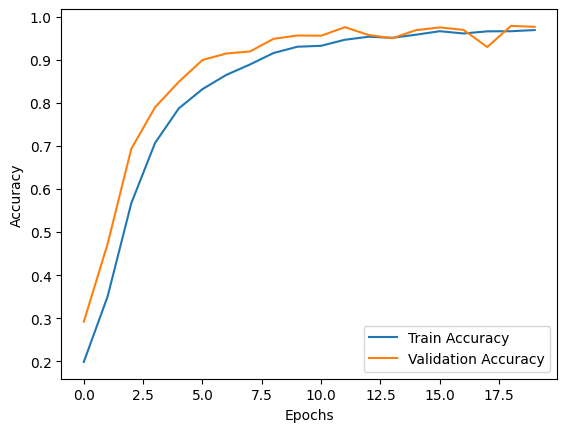

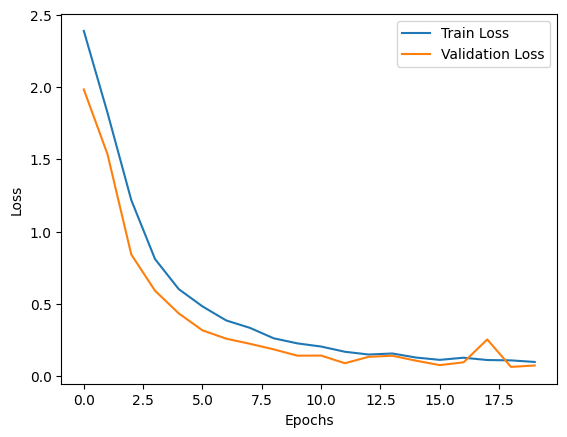

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#çıktının yorumu for me:
training accuracy= 0.95 ile 1 arasında
validation accuracy = 0.95 ile 1 arasında
**Overfitting yok** Eğitim ve doğrulama doğruluklarının bu kadar yakın olması, overfitting olmadığını ve modelin genelleme yeteneğinin iyi olduğunu gösteriyor.
training loss = hızla azalıyor ve ~0.05
validation loss =  paralel bir şekilde azalıyor ve eğitim kaybıyla çok benzer seviyelere ulaşıyor.
**Underfitting yok** Eğitim ve doğrulama kayıplarının birbirine bu kadar yakın olması, modelin doğrulama verisinde de iyi performans gösterdiğini ve underfitting olmadığını ortaya koyuyor.

**Save the Model**

In [ ]:
# Save the model in native Keras format
model.save("/content/drive/MyDrive/ElectiveDesignSignLanguage/lstm_sign_language_model.keras")
print("Model saved successfully in Keras format!")


Model saved successfully in Keras format!


**Evaluating Test Set Performance**

In [ ]:
from tensorflow.keras.models import load_model

# Load the model saved in Keras format
model_path = "/content/drive/MyDrive/ElectiveDesignSignLanguage/lstm_sign_language_model.keras"
loaded_model = load_model(model_path)
print("Model loaded successfully in Keras format!")

Model loaded successfully in Keras format!


In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = loaded_model.evaluate(X_val_np, y_val_encoded, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9758 - loss: 0.0754
Test Loss: 0.07259778678417206
Test Accuracy: 0.976959764957428
